# Transformers

La arquitectura **transformer** es la más usada para resolver tareas de Procesamiento de Lenguaje Natural. Se basa en un **codificador** que recibe un texto de entrada y procesa la información para extraer características de cada una de las palabras en el texto. Puede producir vectores que tienen información semántica de las palabras, a estos vectores se les conoce como **encajes**.

En este notebook veremos algunos ejemplos de cómo se pueden usar los modelos de lenguaje para realizar varias tareas.

## 🔴⚠️ Importante ⚠️🔴

Se recomienda usar una GPU para ejecutar este notebook. En el menú **Entorno de ejecución**, elegir Cambiar tipo de entorno de ejecución y en la sección **Acelerador por hardware** elegir una GPU o TPU.

## Enmascarado de palabra.

La principal tarea que pueden hacer los modelos basados en transformers es la de predecir una palabra enmascarada. Esto se puede hacer mediante la herramienta `pipeline`.

In [1]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModel
import torch
from transformers import pipeline
import matplotlib.pyplot as plt
import numpy as np

In [38]:
model_path = "dccuchile/bert-base-spanish-wwm-cased"
#model_path = "bertin-project/bertin-roberta-base-spanish"
#model_path = "google-bert/bert-base-multilingual-uncased"
#model_path = "guillermoruiz/mex_large"

Los **pipelines** son funciones que nos facilitan las tareas más frecuentes, por ejemplo predecir la palabra enmascarada.

In [39]:
unmasker = pipeline('fill-mask', model=model_path)

Device set to use cuda:0


In [41]:
text_masked = ["Por fin el [MASK] está bajando y ya puedo salir a la calle.",
               "Hoy vamos a comer unos [MASK].",
               "Me la pasé [MASK] la cena todo el día.",
               "Tengo que [MASK] bien porque mañana tengo examen.",
               "Mi propósito es hacer más [MASK].",
               "Me toca ir al [MASK] pero estoy muy cansado.",
               ]
#text_masked = ["Mexico_City _GEO " + t for t in text_masked] # para el caso mex_large
#text_masked = [t.replace(" [MASK]", " <mask>") for t in text_masked] # para el caso de bertin y mex_large
unmasker(text_masked[0])

[{'score': 0.1368665248155594,
  'token': 1505,
  'token_str': 'sol',
  'sequence': 'Por fin el sol está bajando y ya puedo salir a la calle.'},
 {'score': 0.08917335420846939,
  'token': 1577,
  'token_str': 'tiempo',
  'sequence': 'Por fin el tiempo está bajando y ya puedo salir a la calle.'},
 {'score': 0.07710042595863342,
  'token': 5241,
  'token_str': 'cielo',
  'sequence': 'Por fin el cielo está bajando y ya puedo salir a la calle.'},
 {'score': 0.07063408941030502,
  'token': 4425,
  'token_str': 'precio',
  'sequence': 'Por fin el precio está bajando y ya puedo salir a la calle.'},
 {'score': 0.04767605662345886,
  'token': 5994,
  'token_str': 'tráfico',
  'sequence': 'Por fin el tráfico está bajando y ya puedo salir a la calle.'}]

In [42]:
for idx in range(6):
    res = unmasker(text_masked[idx])
    print()
    print(text_masked[idx])
    for r in res:
        print(r['token_str'])


Por fin el [MASK] está bajando y ya puedo salir a la calle.
sol
tiempo
cielo
precio
tráfico

Hoy vamos a comer unos [MASK].
huevos
[UNK]
dulces
pasteles
cereales

Me la pasé [MASK] la cena todo el día.
preparando
haciendo
con
en
comiendo

Tengo que [MASK] bien porque mañana tengo examen.
estar
hacerlo
pensarlo
ponerme
dormir

Mi propósito es hacer más [MASK].
dinero
daño
fuerte
luz
cosas

Me toca ir al [MASK] pero estoy muy cansado.
baño
trabajo
hospital
cine
aeropuerto


## Encajes

Los encajes son vectores que incluyen información semántica de un texto. Los encajes de dos textos similares, van a dar una región similar en el espacio.

Para obtener los encajes de un texto, necesitamos el modelo de lenguaje y su **tokenizador** asociado. El tokenizador se encarga de partir el texto de entrada en **tokens** antes de meterlos al enconder. Un token se puede pensar que es una palabra.

Antes del entrenamiento, se usa el tokenizador para que seleccione la forma en que se va a partir el texto y también debe elegir el **vocabulario** del  modelo. El vocabulario es el conjunto de tokens que reconce el modelo.

Veamos un ejemplo:

Primero cargamos el modelo y su tokenizador. El modelo lo pasamos a la GPU con
```
model.to(device)
```

In [43]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device) ## Con esto verificamos que tengamos un dispositivo con cuda (GPU o TPU).
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path)
model = model.to(device)

cuda:0


Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
tokenizer.vocab_size

31002

In [45]:
#tokenizer.vocab

In [46]:
text = ["Por fin el calor está bajando y ya puedo salir a la calle.",
        "Hoy vamos a comer unos tacos.",
        "Me la pasé cocinando la cena todo el día.",
        "Tengo que dormir bien porque mañana tengo examen.",
        "Mi propósito es hacer más ejercicio.",
        "Me toca ir al gimnasio pero estoy muy cansado.",
        ]
#text = ["Mexico_City _GEO " + t for t in text] # para el caso mex_large


In [50]:
tokenizer.tokenize(text[1])

['Hoy', 'vamos', 'a', 'comer', 'unos', 'tac', '##os', '.']

El tokenizador tiene varias opciones,
- `return_tensors="pt"`: Pedimos que regrese los tokens como un tensor de Pytorch. Esta opción depende de si cargamos el modelo en Pytorch o Tensorflow.
- `padding="max_length"`: Los tensores con los tokens deben tener todos el mismo tamaño. Si un mensaje es más corto, se rellena con el token especial **PADDING**.
- `max_length=20`: Especificamos el tamaño de los tensores.
- `truncation=True`: Los mensajes con más tokens que `max_length` se truncan.

In [51]:
tokens = tokenizer(text, return_tensors="pt", padding='max_length', max_length=20, truncation=True)

In [52]:
tokens

{'input_ids': tensor([[    4,  1278,  1377,  1040,  7110,  1266, 21137,  1042,  1526,  1769,
          3143,  1013,  1030,  3783,  1009,     5,     1,     1,     1,     1],
        [    4,  4894,  2229,  1013,  2073,  2438, 16718,  1011,  1009,     5,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
        [    4,  1369,  1030, 15748,  6765, 30935,  1047,  1030,  6997,  1397,
          1040,  1726,  1009,     5,     1,     1,     1,     1,     1,     1],
        [    4,  2190,  1038,  5182,  1311,  1817,  2591,  1847,  4165,  1009,
             5,     1,     1,     1,     1,     1,     1,     1,     1,     1],
        [    4,  1451,  6079,  1058,  1409,  1216,  4376,  1009,     5,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
        [    4,  1369,  9537,  1628,  1091, 17680,  1355,  1764,  1456, 10634,
          1009,     5,     1,     1,     1,     1,     1,     1,     1,     1]]), 'token_type_ids': tensor([[0, 

A todos los mensajes se les agrega un token de inicio y uno de fin (en este caso son el 4 y 5). El texto y los tokens se pueden ver con `decode`.

In [53]:
tokenizer.decode(tokens['input_ids'][0])

'[CLS] Por fin el calor está bajando y ya puedo salir a la calle. [SEP] [PAD] [PAD] [PAD] [PAD]'

Como el modelo están en la GPU, primero debemos mandar los tensores `input_ids` y `attention_mask` a la GPU. Después, los tensores ya se pueden meter al modelo.

In [54]:
with torch.no_grad():
  t = {"input_ids": tokens['input_ids'].to(device), "attention_mask": tokens['attention_mask'].to(device)}
  output = model(**t)

La salida se guarda en la variable `output`. Los encajes de los tokens se guardan en `last_hidden_state`

In [55]:
output.last_hidden_state.shape

torch.Size([6, 20, 768])

Es común que se use el vector asociado al primer token (el de inicio de oración) para describir el texto completo.

In [56]:
emb = output.last_hidden_state[:,0]
emb.shape

torch.Size([6, 768])

Ahora vamos a comparar los encajes de las 5 oraciones de ejemplo.

tensor([[1.0000, 0.8781, 0.9023, 0.8528, 0.8254, 0.9104],
        [0.8781, 1.0000, 0.8121, 0.9223, 0.8188, 0.9105],
        [0.9023, 0.8121, 1.0000, 0.7355, 0.6920, 0.8267],
        [0.8528, 0.9223, 0.7355, 1.0000, 0.8666, 0.9342],
        [0.8254, 0.8188, 0.6920, 0.8666, 1.0000, 0.8875],
        [0.9104, 0.9105, 0.8267, 0.9342, 0.8875, 1.0000]], device='cuda:0')


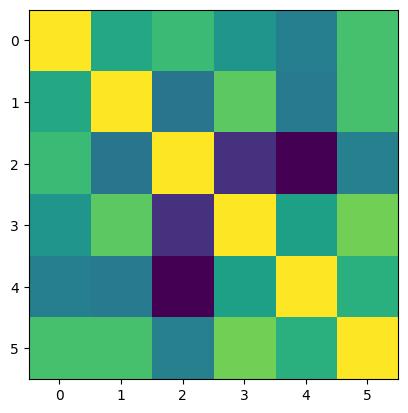

In [57]:
emb = torch.nn.functional.normalize(emb, p=2, dim=1)
sim = emb @ emb.T
print(sim)
plt.imshow(sim.cpu())
plt.show()

In [58]:
text

['Por fin el calor está bajando y ya puedo salir a la calle.',
 'Hoy vamos a comer unos tacos.',
 'Me la pasé cocinando la cena todo el día.',
 'Tengo que dormir bien porque mañana tengo examen.',
 'Mi propósito es hacer más ejercicio.',
 'Me toca ir al gimnasio pero estoy muy cansado.']

Cuando queremos obtener los encajes de una gran cantidad de textos, se recomienda hacerlo por lotes para no revasar la memoria RAM de la tarjeta de video.

In [59]:
text*5

['Por fin el calor está bajando y ya puedo salir a la calle.',
 'Hoy vamos a comer unos tacos.',
 'Me la pasé cocinando la cena todo el día.',
 'Tengo que dormir bien porque mañana tengo examen.',
 'Mi propósito es hacer más ejercicio.',
 'Me toca ir al gimnasio pero estoy muy cansado.',
 'Por fin el calor está bajando y ya puedo salir a la calle.',
 'Hoy vamos a comer unos tacos.',
 'Me la pasé cocinando la cena todo el día.',
 'Tengo que dormir bien porque mañana tengo examen.',
 'Mi propósito es hacer más ejercicio.',
 'Me toca ir al gimnasio pero estoy muy cansado.',
 'Por fin el calor está bajando y ya puedo salir a la calle.',
 'Hoy vamos a comer unos tacos.',
 'Me la pasé cocinando la cena todo el día.',
 'Tengo que dormir bien porque mañana tengo examen.',
 'Mi propósito es hacer más ejercicio.',
 'Me toca ir al gimnasio pero estoy muy cansado.',
 'Por fin el calor está bajando y ya puedo salir a la calle.',
 'Hoy vamos a comer unos tacos.',
 'Me la pasé cocinando la cena todo 

In [60]:
tokens = tokenizer(text*500, return_tensors="pt", padding='max_length', max_length=128, truncation=True)

In [61]:
tokens['input_ids'].shape

torch.Size([3000, 128])

In [62]:
with torch.no_grad():
  t = {"input_ids": tokens['input_ids'].to(device), "attention_mask": tokens['attention_mask'].to(device)}
  output = model(**t)
output.last_hidden_state.shape

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.39 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.35 GiB is free. Process 3181 has 13.39 GiB memory in use. Of the allocated memory 8.71 GiB is allocated by PyTorch, and 4.56 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Con este código se pueden obtener los encajes de una gran cantidad de textos.




In [63]:
def predict(text, bs=128):
    output = []
    for i in range(0, len(text), bs):
        if i//bs%100==99:
            print(i, "/", len(text))
        tokens = tokenizer(text[i: i+bs], return_tensors="pt", padding='max_length', max_length=50, truncation=True)
        t = {"input_ids": tokens['input_ids'].to(device), "attention_mask": tokens['attention_mask'].to(device)}

        with torch.no_grad():
            pred = model(**t).last_hidden_state[:,0].cpu()
        output.append(pred)
    output = torch.cat(output, dim=0)
    return output

In [64]:
output = predict(text*1000)
output.shape

torch.Size([6000, 768])

Se normalizan los vectores y se guardan en el archivo **encajes.pt**

In [65]:
output = torch.nn.functional.normalize(output, p=2, dim=1)
torch.save(output, "encajes.pt")

## Ejercicio
Usar los datos del archivo **emojis_train.csv**. Son 11774 mensajes de Twitter etiquetados con los emojis ❤, 🥺, 😭 y 😊 con la siguiente distribución:

|Emoji|Total|
|---|---|
|❤	|4738|
|🥺	|3654|
|😭	|2182|
|😊	|1200|

Usando los modelos
- google-bert/bert-base-multilingual-uncased
- dccuchile/bert-base-spanish-wwm-cased
- bertin-project/bertin-roberta-base-spanish
- guillermoruiz/mex_large

obtener los encajes de los mensajes y normalizarlos (ponerlos con norma 1). Usar UMAP para graficar los vectores y colorearlos deacuerdo a su etiqueta.

Comparar los gráficos y argumentar las diferencias.

Por ejemplo, en la siguiente imagen se muestran los encajes usando Beto.

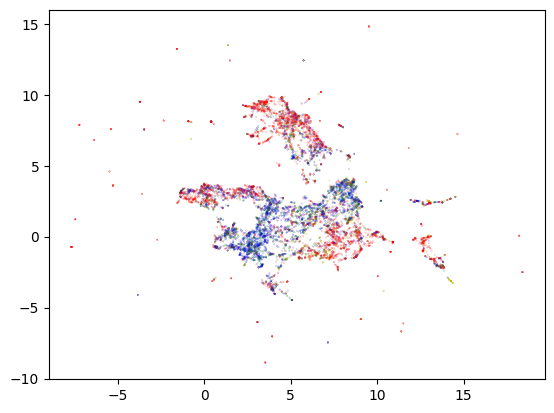